In [1]:
#
# import utilitaires
#
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

import helpers as hlp
import helpers.dataset.PlantVillage as pv
import helpers.features as feat
import helpers.visual_words as vw

In [2]:
#
# dataset PlantVillage
#
config_overrides = hlp.MetaObject.from_json("config_overrides.json")
executor = hlp.create_thread_pool_executor(max_workers=None)

pv_config = pv.Config()
if not config_overrides is None:
    hlp.MetaObject.override_from_object(pv_config, 
                                        config_overrides.dataset)

pv_dataset = pv.load(pv_config)
pv_dataframe = pv_dataset.dataframe

print("Dataset", pv_dataframe.shape)
print()

# ----------------------------


#
# features orb
#
orb_features_config = feat.OrbFeaturesConfig()
if not orb_features_config is None:
    hlp.MetaObject.override_from_object(orb_features_config, 
                                        config_overrides.orb.features)

orb_features = feat.load(orb_features_config, None)
print("ORB features:", orb_features.features.shape)

#
# bag of visual words orb
#
orb_bovw_config = vw.BoVWConfig()
if not config_overrides is None:
    hlp.MetaObject.override_from_object(orb_bovw_config, 
                                        config_overrides.orb.bovw)

orb_bovw = vw.load_bovw(orb_bovw_config, None)
orb_bovw_cluster_count = orb_bovw.model.cluster_centers_.shape[0]

print("ORB BoVW clusters:", orb_bovw.model.cluster_centers_.shape)
print()

# ----------------------------


#
# features sift
#
sift_features_config = feat.SiftFeaturesConfig()
if not sift_features_config is None:
    hlp.MetaObject.override_from_object(sift_features_config, 
                                        config_overrides.sift.features)

sift_features = feat.load(sift_features_config, None)
print("Sift features:", sift_features.features.shape)

#
# bag of visual words sift
#
sift_bovw_config = vw.BoVWConfig()
if not config_overrides is None:
    hlp.MetaObject.override_from_object(sift_bovw_config, 
                                        config_overrides.sift.bovw)

sift_bovw = vw.load_bovw(sift_bovw_config, None)
sift_bovw_cluster_count = sift_bovw.model.cluster_centers_.shape[0]

print("Sift BoVW clusters:", sift_bovw.model.cluster_centers_.shape)


#
# objet wrapper qui permet de tout processer
#
sift_visual_words = vw.VisualWords(sift_features_config, sift_bovw.model)

Dataset (60343, 5)

ORB features: (20908751, 32)
ORB BoVW clusters: (500, 32)

Sift features: (14386568, 128)
Sift BoVW clusters: (500, 128)


In [3]:
#
# export en batch des visual words orb
#

orb_pv_vw_config = vw.DatasetVWConfig(executor)
if not config_overrides is None:
    hlp.MetaObject.override_from_object(orb_pv_vw_config, 
                                        config_overrides.orb.dataset_vw)
    
print("ORB Dataset Visual Words config")
display(vars(orb_pv_vw_config))

# pour debugger, s'assurer que le fichier de visual words 
# est detruit a chaque execution de la cellule
if "orb_pv_vw" in locals():
    del orb_pv_vw

with hlp.Profile() as orb_pv_vw_loading:
    #
    # obtenir les orb features pour chaque image du dataset
    #
    orb_iter = feat.DatasetIter(pv_dataset, 
                                pv_dataframe["image_path"].iteritems(),
                                pv_dataframe.shape[0])
    orb_pv_vw = vw.load_dataset_vw(orb_pv_vw_config, 
                                   orb_features,
                                   orb_bovw.model,
                                   orb_iter)

print(f"ORB PlantVillage Visual Word loading:", orb_pv_vw_loading.round_duration(), "s")
print("ORB PlantVillage Visual Words", orb_pv_vw.h5_vw_freqs.shape)

ORB Dataset Visual Words config


{'install_path': 'dataset/OrbVW.hd5',
 'force_generate': False,
 'read_only': True,
 'executor': <concurrent.futures.thread.ThreadPoolExecutor at 0x2859fec89a0>,
 'chunk_size': 150}

ORB PlantVillage Visual Word loading: 0.0 s
ORB PlantVillage Visual Words (60162, 500)


In [4]:
#
# export en batch des visual words sift
#

sift_pv_vw_config = vw.DatasetVWConfig(executor)
if not config_overrides is None:
    hlp.MetaObject.override_from_object(sift_pv_vw_config, 
                                        config_overrides.sift.dataset_vw)
    
print("Sift Dataset Visual Words config")
display(vars(sift_pv_vw_config))

# pour debugger, s'assurer que le fichier de visual words 
# est detruit a chaque execution de la cellule
if "sift_pv_vw" in locals():
    del sift_pv_vw

with hlp.Profile() as sift_pv_vw_loading:
    #
    # obtenir les sift features pour chaque image du dataset
    #
    sift_iter = feat.DatasetIter(pv_dataset, 
                                 pv_dataframe["image_path"].iteritems(),
                                 pv_dataframe.shape[0])
    sift_pv_vw = vw.load_dataset_vw(sift_pv_vw_config, 
                                    sift_features,
                                    sift_bovw.model,
                                    sift_iter)

print(f"sift PlantVillage Visual Word loading:", sift_pv_vw_loading.round_duration(), "s")
print("sift PlantVillage Visual Words", sift_pv_vw.h5_vw_freqs.shape)

Sift Dataset Visual Words config


{'install_path': 'dataset/SiftVW.hd5',
 'force_generate': False,
 'read_only': True,
 'executor': <concurrent.futures.thread.ThreadPoolExecutor at 0x2859fec89a0>,
 'chunk_size': 25}

sift PlantVillage Visual Word loading: 0.02 s
sift PlantVillage Visual Words (60337, 500)


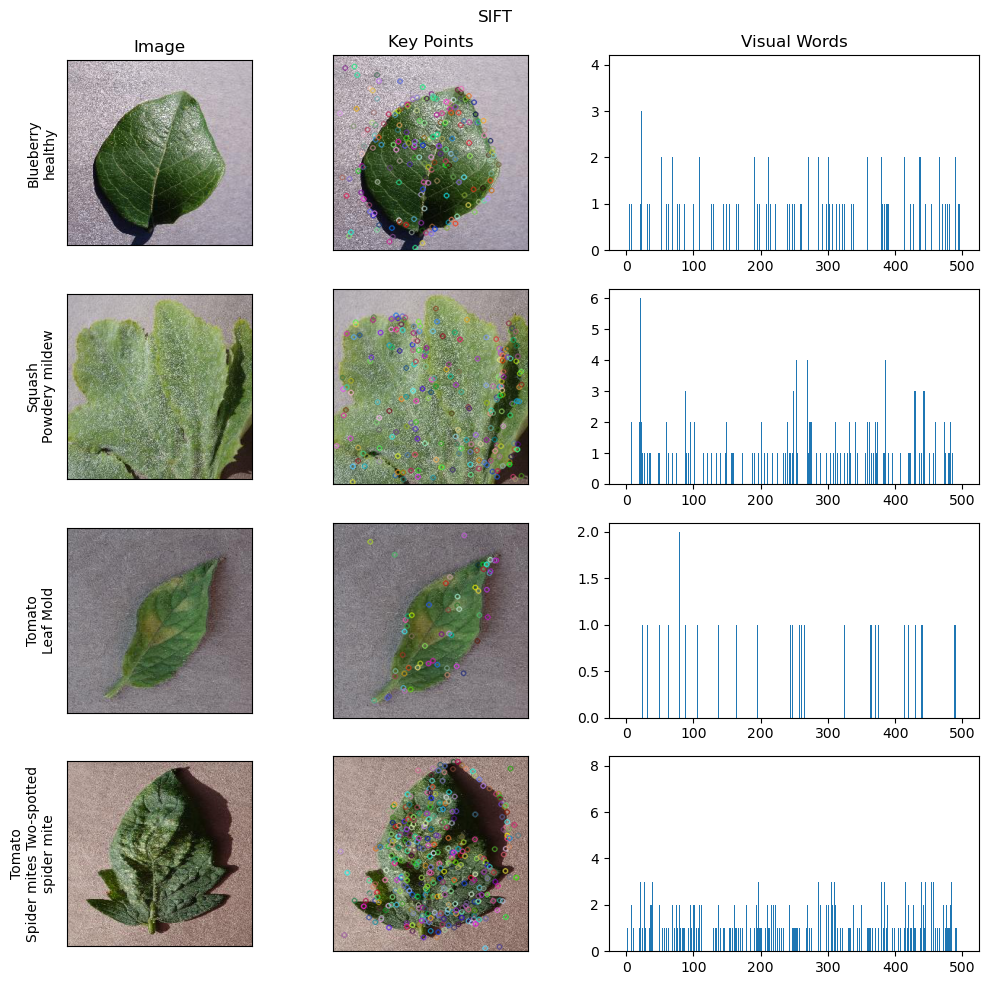

In [5]:
#
# visualiser quelques visual words
#

# objet wrapper qui permet de tout processer
if True:
    visual_words = vw.VisualWords(sift_features_config, sift_bovw.model)
    bovw_cluster_count = sift_bovw_cluster_count
    vw_title = "SIFT"
else:
    visual_words = vw.VisualWords(orb_features_config, orb_bovw.model)
    bovw_cluster_count = orb_bovw_cluster_count
    vw_title = "ORB"

SAMPLES_GRID = (4, 3)
SAMPLES_COUNT = SAMPLES_GRID[0]
FIGSIZE = (10, SAMPLES_GRID[0] * 2.5)

# selectionner quelques images aleatoirement
random.seed(72)
image_indices = random.sample(range(pv_dataframe.shape[0]), SAMPLES_COUNT)
image_indices.sort()

x_range = range(bovw_cluster_count)
figure, axes = plt.subplots(SAMPLES_GRID[0],
                            SAMPLES_GRID[1],
                            figsize=FIGSIZE,
                            width_ratios=[1, 2, 2])

for i, image_index in enumerate(image_indices):
    image = pv_dataset.get_image(image_index)

    key_points, features, visual_words_freq = visual_words.extract(image)

    if key_points is None:
        continue

    image_key_points = visual_words.draw_key_points(image, key_points)

    ## TODO: semble avoir un bug avec ca, a valider
    #visual_words_freq2 = orb_pv_vw.h5_index_to_vw_freqs[str(image_index)][...].flatten()

    species, disease = pv_dataframe.loc[image_index, ["species", "disease"]]
    disease = pv.attribute_prettify(species, disease)
    title = "\n".join([species, disease])

    plt.sca(axes[i, 0])
    plt.gca().set_ylabel(title)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.imshow(image)

    plt.sca(axes[i, 1])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.imshow(image_key_points)

    plt.sca(axes[i, 2])
    plt.bar(x_range, visual_words_freq)

#     plt.sca(axes[i, 2])
#     plt.bar(x_range, visual_words_freq2)

axes[0, 0].set_title("Image")
axes[0, 1].set_title("Key Points")
axes[0, 2].set_title("Visual Words")
# axes[0, 2].set_title("Distribution Cache")

plt.suptitle(vw_title)
plt.tight_layout()
plt.show()

# figure.savefig(f"{vw_title}_visual_words.png")